In [1]:
!date

Mon Aug 11 01:44:05 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
!which python

~/anaconda3/envs/DeNN/bin/python


In [4]:
import sys
print(sys.executable)

/home/aglinska/anaconda3/envs/DeNN/bin/python


In [5]:
import nibabel as nib
import os
import random
import matplotlib.pyplot as plt
import sys
import numpy
np = numpy
print(numpy.__version__)
import h5py

import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Input,LSTM,TimeDistributed,concatenate,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as T
from tensorflow.keras.constraints import non_neg,Constraint
dense_size = 128

import scipy
import scipy.io as si
from scipy.stats.mstats import zscore
from scipy.io import savemat
import sklearn
from sklearn.model_selection import train_test_split

1.24.3


2025-08-11 13:44:06.413636: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 13:44:06.478503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 13:44:06.529475: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 13:44:06.530122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-11 13:44:07.746477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
print(f'nib: {nib.__version__}')
print(f'numpy: {numpy.__version__}')
print(f'tf: {tf.__version__}')
print(f'scipy: {scipy.__version__}')
print(f'sklearn: {sklearn.__version__}')

nib: 5.2.1
numpy: 1.24.3
tf: 2.13.1
scipy: 1.10.1
sklearn: 1.3.2


In [7]:
#tf.compat.v1.disable_v2_behavior()   # back to graph mode, brings back tf.get_default_graph

In [8]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2) force TF deterministic behavior (disable oneDNN optimizations if needed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# 3) standard RNG seeds
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

# 4) TensorFlow 2.x seed
import tensorflow as tf
tf.random.set_seed(SEED)

# 5) for TF1 graph mode (since you call disable_v2_behavior)
tf.compat.v1.set_random_seed(SEED)

In [9]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [10]:
# DeNN model structure
def denoise_model_general(tdim,layers_type=["tden","tdis","tdis","conv","conv","conv"],layers_size=[128,32,16,8,4,1]):
    """
        denoise_model_general(tdim,layers_type,layers_size):
            Time-dependent fully-connected layers are required to be before all the other layers. Multiple time-dependent layers can be specified.
            layers_type: list, with element value as "tden","tdis","conv",e.g. ["tden","tdis","tdis","conv","conv","conv"]
            layers_size: list, e.g. [128,32,16,8,4,1]
    """
    input_fMRI = [Input(shape=(1,1)) for i in range(tdim)]
    input_dwt = [Input(shape=(1,1)) for i in range(tdim)]
    output_fMRI = input_fMRI
    output_dwt = input_dwt
    if len(layers_type)!=len(layers_size):
        print("error: the size for layers_type and layers_size do not match")
        return 0
    elif layers_size[-1]!=1:
        print("error: the size for the last layer has to be 1")
        return 0
    else:
        for layer_ind,layer_name in enumerate(layers_type):
            if layer_name=="tden":
                layer = [Dense(layers_size[layer_ind],activation='linear') for i in range(tdim)]
                output_fMRI = [layer[i](output_fMRI[i]) for i in range(tdim)]
                output_dwt = [layer[i](output_dwt[i]) for i in range(tdim)]
                if layer_ind==len(layers_type)-1 or layers_type[layer_ind+1]!="tden":
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
            elif layer_name=="conv":
                if layer_ind==0:
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
                layer = Conv1D(layers_size[layer_ind],5,padding='same')
                output_fMRI = layer(output_fMRI)
                output_dwt = layer(output_dwt)
            elif layer_name == "tdis":
                if layer_ind==0:
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
                layer = TimeDistributed(Dense(layers_size[layer_ind],activation='linear'))
                output_fMRI = layer(output_fMRI)
                output_dwt = layer(output_dwt)
        merged_data = concatenate([output_fMRI,output_dwt],axis=-1)
        model = Model(inputs = input_fMRI+input_dwt,outputs = merged_data)
        return model

In [11]:
def denoise_loss(y_true,y_pred):
    output_fMRI = y_pred[:,:,0]
    output_dwt  = y_pred[:,:,1]
    tdim = output_fMRI.shape[1]
    tdim = float(tdim)
    output_fMRI = output_fMRI - T.mean(output_fMRI,axis=-1,keepdims=True)
    output_dwt  = output_dwt - T.mean(output_dwt,axis = -1,keepdims=True)
    output_fMRI = output_fMRI/T.std(output_fMRI,axis=-1,keepdims=True)
    output_dwt  = output_dwt/T.std(output_dwt,axis=-1,keepdims=True)
    corr_mat = T.dot(output_fMRI,T.transpose(output_fMRI))/tdim
    corr_fMRI = T.mean(T.abs(corr_mat))/2
    corr_mat = T.dot(output_dwt,T.transpose(output_dwt))/tdim
    corr_dwt = T.mean(T.abs(corr_mat))/2
    corr_mat = T.dot(output_fMRI,T.transpose(output_dwt))/tdim
    corr_fMRIdwt = T.mean(T.abs(corr_mat))
    return corr_fMRIdwt #corr_dwt - corr_fMR

In [12]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [13]:
## Data Specification

In [14]:
# Parameters for looping. 
s = 0 # index for subject (out of 14)
r = 1 # index for run (out of 4)
analysis_name = 'test' # This is be appended to the saved output files

In [15]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/test


In [16]:
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs_orig.sort()

n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')

sub = subs_orig[s]
sub

'sub-01'

In [17]:
func = nib.load(epi_fn.format(sub=sub,r=r))
roni_idx = nib.load(cf_fn)
roi_idx = nib.load(gm_fn)

gm_mask_c = roi_idx.get_fdata()==1
cf_mask_c = roni_idx.get_fdata()==1

In [18]:
# Extract functional data from masks
func_values = func.get_fdata()#[:,:,:,5:]
func_reshaped = np.reshape(func_values,[func.shape[0]*func.shape[1]*func.shape[2],func.shape[3]])
gm_reshaped = np.reshape(gm_mask_c,-1)
cf_reshaped = np.reshape(cf_mask_c,-1)
func_gm = func_reshaped[gm_reshaped,:] # these are the functional data in gray matter
func_cf = func_reshaped[cf_reshaped,:] # these are the functional data in the regions of no interest

In [19]:
def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

class Scaler():
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large


In [20]:
#Normalization of Data
func_gm = remove_std0(func_gm)
func_cf = remove_std0(func_cf)

obs_scale = Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
noi_scale = Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)

In [21]:
func_gm.shape

(41116, 156)

In [22]:
print(obs_list.shape)
print(noi_list.shape)

(41116, 156)
(9092, 156)


In [23]:
obs_train = obs_list

In [24]:
obs_list = numpy.reshape(obs_list,obs_list.shape+(1,))
noi_list = numpy.reshape(noi_list,noi_list.shape+(1,))

In [25]:
print(obs_list.shape)
print(noi_list.shape)
if obs_list.shape[0]>noi_list.shape[0]:
    n_pad = obs_list.shape[0]-noi_list.shape[0]
    pad_idx = np.random.randint(low=0,high=noi_list.shape[0],size=n_pad)
    noi_list = np.concatenate([noi_list,np.array([noi_list[i,:] for i in pad_idx])])
    print(obs_list.shape)
    print(noi_list.shape)

(41116, 156, 1)
(9092, 156, 1)
(41116, 156, 1)
(41116, 156, 1)


In [26]:
mid = obs_list.shape[0]//2

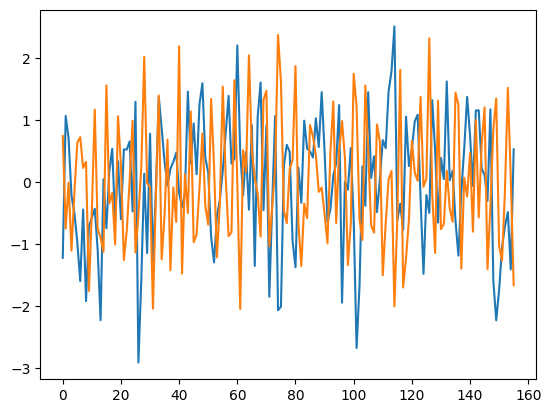

In [27]:
plt.plot(obs_list[mid,:])
plt.plot(noi_list[mid,:])

In [28]:
obs_train = obs_list
nvoxel_train = obs_train.shape[0]
trainind_c23 = numpy.random.permutation(noi_list.shape[0])[:nvoxel_train]
tdim = obs_train.shape[1]

In [29]:
print(obs_train.shape)
print(trainind_c23.shape)

(41116, 156, 1)
(41116,)


In [30]:
obs_train.shape

(41116, 156, 1)

In [31]:
model = denoise_model_general(tdim,layers_type=["tden","tdis","tdis","conv","conv","conv"],layers_size=[128,32,16,8,4,1])
opt = Adam(lr=0.05,beta_1=0.9, beta_2 = 0.999)
model.compile(optimizer=opt,loss=denoise_loss)
epochs = 100
train_c1 = obs_train
train_c23= noi_list[trainind_c23,:,:]
y_true = numpy.ones((nvoxel_train,tdim,2))
all_loss = []

history = model.fit([train_c1[:,[i],:] for i in range(tdim)]+
                    [train_c23[:,[i],:] for i in range(tdim)],
                    y=y_true,batch_size = 5000,validation_split=0.15/0.85,epochs = epochs)

fMRIdata_q_output = model.predict([train_c1[:,[i],:] for i in range(tdim)]+
                                    [train_c1[:,[i],:] for i in range(tdim)]
                                    ,batch_size=500)
loss = history.history['loss']
valloss = history.history['val_loss']

2025-08-11 13:44:11.750505: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/aglinska/anaconda3/envs/DeNN/lib/python3.8/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
7/7 [==============================] - 24s 2s/step - loss: 0.2213 - val_loss: 0.1423
Epoch 2/10
7/7 [==============================] - 5s 709ms/step - loss: 0.1285 - val_loss: 0.1151
Epoch 3/10
7/7 [==============================] - 5s 710ms/step - loss: 0.1163 - val_loss: 0.1065
Epoch 4/10
7/7 [==============================] - 5s 708ms/step - loss: 0.1102 - val_loss: 0.1039
Epoch 5/10
7/7 [==============================] - 5s 711ms/step - loss: 0.1070 - val_loss: 0.1010
Epoch 6/10
7/7 [==============================] - 5s 703ms/step - loss: 0.1051 - val_loss: 0.0989
Epoch 7/10
7/7 [==============================] - 5s 709ms/step - loss: 0.1034 - val_loss: 0.0977
Epoch 8/10
7/7 [==============================] - 5s 700ms/step - loss: 0.1020 - val_loss: 0.0962
Epoch 9/10
7/7 [==============================] - 5s 699ms/step - loss: 0.1007 - val_loss: 0.0947
Epoch 10/10
83/83 [==============================] - 8s 28ms/step


In [32]:
fMRIdata_q_output.shape

(41116, 156, 2)

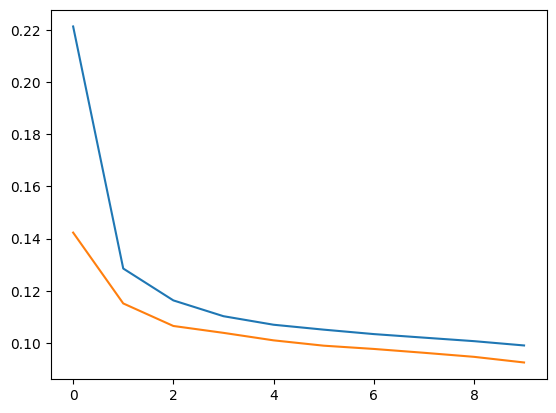

In [33]:
plt.plot(loss)
plt.plot(valloss)

In [34]:
idx = gm_mask_c
idx*=func_values.std(axis=-1)>1e-3
idx.sum()

new_arr = np.zeros(func_values.shape)
new_arr[gm_mask_c,:]=fMRIdata_q_output[:,:,0]

new_img = nib.Nifti1Image(new_arr, affine=func.affine, header=func.header)
nib.save(new_img, os.path.join(ofdir,f'DeNN-Denoised-S{s}-R{r}.nii.gz'))

In [35]:
np.save(file=os.path.join(ofdir,f'loss-S{s}-R{r}.nii.gz'),arr=loss)
np.save(file=os.path.join(ofdir,f'valloss-S{s}-R{r}.nii.gz'),arr=valloss)